In [ ]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Recurrence-based Seq2Seq Neural Machine Translation Without Attention

Model kami hanya menggunakan dua LSTM (satu encoder dan satu decoder) untuk menerjemahkan

Dataset yang akan kita gunakan berasal dari file .srt yang dibah ke .txt

In [ ]:
# Upload the training set.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Endgame/endgmsubdatasets(3)_train.txt


Saving endgmsubdatasets(3)_train.txt to endgmsubdatasets(3)_train.txt


{'endgmsubdatasets(3)_train.txt': b"\xef\xbb\xbfOke, tunggu, jangan tembak.<sep>Okay, hold on, don't shoot.\r\nAnda melihat ke mana Anda pergi?  Mm-hmm.<sep>You see where you're going? Mm-hmm.\r\nOke.<sep>Okay.\r\nSekarang, mari kita khawatir tentang bagaimana Anda sampai di sana.<sep>Now, let's worry about how you get there.\r\nHarus pindah kaki Anda di sini.<sep>Gotta move your foot here.\r\nArahkan jari kaki Anda ke sini.<sep>Point your toe this way.\r\nPinggul Anda di sini.<sep>Your hips here.\r\nOke?<sep>Okay?\r\nBisakah kamu melihat?  Ya.<sep>Can you see? Yeah.\r\nApa kamu yakin?  Mm-hmm.<sep>Are you sure? Mm-hmm.\r\nBagaimana kalau sekarang?  Bisakah kamu melihat sekarang?<sep>How about now? Can you see now?\r\nTidak. Bagaimana dengan sekarang?<sep>No. How about now?\r\nBaiklah.<sep>All right.\r\nSiap?  Tiga jari.<sep>Ready? Three fingers.\r\nBagus!<sep>Nice!\r\nLemparan yang bagus, Nak.<sep>Nice throw, kiddo.\r\nIni dia.<sep>Here you go.\r\nHei, kalian mau mayo?  Atau mustar?<s

In [ ]:
with open('endgmsubdatasets(3)_train.txt', encoding='utf-8-sig') as file:
  train = [line.rstrip() for line in file]



Setiap entri terdiri dari kalimat subtittle Indonesia diikuti dengan translasi bahasa Inggrisnya, dipisahkan oleh pembatas (sep)

In [ ]:
train[:3]

["Oke, tunggu, jangan tembak.<sep>Okay, hold on, don't shoot.",
 "Anda melihat ke mana Anda pergi?  Mm-hmm.<sep>You see where you're going? Mm-hmm.",
 'Oke.<sep>Okay.']

In [ ]:
len(train)

2330

In [ ]:
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train]))

In [ ]:
print(train_input[:3])
print(train_target[:3])

['Oke, tunggu, jangan tembak.', 'Anda melihat ke mana Anda pergi?  Mm-hmm.', 'Oke.']
["Okay, hold on, don't shoot.", "You see where you're going? Mm-hmm.", 'Okay.']


Penerapan normalisasi Unicode

In [ ]:
print("\u00E1", "\u0061\u0301")

á á


In [ ]:
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

Fungsi ini akan menampilkan tanda baca sebagai token terpisah dan normalisasi unicode.

In [ ]:
def preprocess_sentence(s):
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [ ]:
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

Setelah preprocessing, unicode harus dinormalisasi dan harus ada spasi di kedua sisi tanda baca.

In [ ]:
train_preprocessed_input[:3]

['Oke , tunggu , jangan tembak .',
 'Anda melihat ke mana Anda pergi ? Mm-hmm .',
 'Oke .']

Menggunakan Teacher Forcing yang menempatkan tag awal kalimat (sos) dan tag akhir kalimat (eos) masing-masing di awal dan akhir setiap kalimat target.

In [ ]:
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [ ]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [ ]:
train_tagged_preprocessed_target[:3]

["<sos> Okay , hold on , don't shoot . <eos>",
 "<sos> You see where you're going ? Mm-hmm . <eos>",
 '<sos> Okay . <eos>']

Tokenize kalimat input dan target.

Menyertakan token out-of-vocabulary (oov) dalam inisialisasi tokenizer.

Pada waktu inferensi, jika tokenizer menemukan kata yang tidak dilihatnya selama penyesuaian awal pada training data, kata tersebut akan diganti dengan (oov) dan sistem terjemahan harus mengatasinya.

In [ ]:
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 2330,
 'word_counts': '{"oke": 42, ",": 733, "tunggu": 20, "jangan": 21, "tembak": 2, ".": 2587, "anda": 302, "melihat": 28, "ke": 56, "mana": 26, "pergi": 40, "?": 447, "mm": 8, "hmm": 8, "sekarang": 41, "mari": 4, "kita": 134, "khawatir": 8, "tentang": 25, "bagaimana": 31, "sampai": 10, "di": 186, "sana": 26, "harus": 50, "pindah": 3, "kaki": 2, "sini": 52, "arahkan": 1, "jari": 3, "pinggul": 1, "bisakah": 14, "kamu": 102, "ya": 111, "apa": 156, "yakin": 7, "kalau": 3, "tidak": 363, "dengan": 65, "baiklah": 29, "siap": 4, "tiga": 11, "bagus": 23, "!": 136, "lemparan": 1, "yang": 277, "nak": 5, "ini": 167, "dia": 139, "hei": 26, "kalian": 11, "mau": 5, "mayo": 3, "atau": 23, "mustar": 2, "keduanya": 4, "siapa": 27, "menaruh": 1, "atas": 8, "hot": 1, "dog": 1, "mungkin": 36, "saudara": 2, "saudaramu": 2, "uh": 9, "dua": 17, "to

In [ ]:
source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

1960


In [ ]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 2330,
 'word_counts': '{"<sos>": 2330, "okay": 52, ",": 816, "hold": 5, "on": 104, "don\'t": 70, "shoot": 1, ".": 2595, "<eos>": 2330, "you": 446, "see": 30, "where": 38, "you\'re": 60, "going": 28, "?": 447, "mm": 8, "hmm": 8, "now": 41, "let\'s": 14, "worry": 5, "about": 44, "how": 30, "get": 59, "there": 43, "gotta": 16, "move": 11, "your": 62, "foot": 1, "here": 65, "point": 11, "toe": 1, "this": 117, "way": 28, "hips": 1, "can": 44, "yeah": 72, "are": 83, "sure": 8, "no": 123, "all": 80, "right": 81, "ready": 4, "three": 12, "fingers": 4, "nice": 7, "!": 136, "throw": 2, "kiddo": 1, "go": 34, "hey": 44, "guys": 23, "want": 23, "mayo": 3, "or": 23, "mustard": 3, "both": 7, "who": 29, "puts": 1, "a": 234, "hot": 4, "dog": 1, "probably": 7, "brothers": 1, "uh": 33, "two": 19, "please": 18, "thanks": 6, "mama": 1, "got": 58, "

In [ ]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

1917


Vectorize kalimat input dan target.

In [ ]:
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [ ]:
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[47, 3, 92, 3, 90, 578, 2], [7, 68, 34, 74, 7, 49, 4, 208, 209, 2], [47, 2]]
['oke , tunggu , jangan tembak .', 'anda melihat ke mana anda pergi ? mm hmm .', 'oke .']


Fungsi di bawah mengambil kumpulan kalimat, memvektorisasi, lalu menjadikan masing-masing dua salinan. Yang pertama akan menyertakan setiap token kecuali yang terakhir. Yang kedua akan menyertakan setiap token kecuali yang pertama.

In [ ]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs]
  decoder_targets = [s[1:] for s in seqs]

  return decoder_inputs, decoder_targets

In [ ]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)

In [ ]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[3, 53, 5, 340, 24, 5, 38, 851, 2] [53, 5, 340, 24, 5, 38, 851, 2, 4]
["<sos> okay , hold on , don't shoot ."] ["okay , hold on , don't shoot . <eos>"]


Mengisi semua urutan dengan panjang yang seragam.

In [ ]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

21

In [ ]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

21

In [ ]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [ ]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[ 47   3  92   3  90 578   2   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[  3  53   5 340  24   5  38 851   2   0   0   0   0   0   0   0   0   0
   0   0   0]
[ 53   5 340  24   5  38 851   2   4   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

["<sos> okay , hold on , don't shoot . <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>"]

Menyiapkan dataset validasi.

In [ ]:
# Upload validation set pairs.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Endgame/endgmsubdatasets(3)_val.txt

Saving endgmsubdatasets(3)_val.txt to endgmsubdatasets(3)_val.txt


{'endgmsubdatasets(3)_val.txt': b"\xef\xbb\xbfOke, tunggu, jangan tembak.<sep>Okay, hold on, don't shoot.\r\nAnda melihat ke mana Anda pergi?  Mm-hmm.<sep>You see where you're going? Mm-hmm.\r\nOke.<sep>Okay.\r\nSekarang, mari kita khawatir tentang bagaimana Anda sampai di sana.<sep>Now, let's worry about how you get there.\r\nHarus pindah kaki Anda di sini.<sep>Gotta move your foot here.\r\nArahkan jari kaki Anda ke sini.<sep>Point your toe this way.\r\nPinggul Anda di sini.<sep>Your hips here.\r\nOke?<sep>Okay?\r\nBisakah kamu melihat?  Ya.<sep>Can you see? Yeah.\r\nApa kamu yakin?  Mm-hmm.<sep>Are you sure? Mm-hmm.\r\nBagaimana kalau sekarang?  Bisakah kamu melihat sekarang?<sep>How about now? Can you see now?\r\nTidak. Bagaimana dengan sekarang?<sep>No. How about now?\r\nBaiklah.<sep>All right.\r\nSiap?  Tiga jari.<sep>Ready? Three fingers.\r\nBagus!<sep>Nice!\r\nLemparan yang bagus, Nak.<sep>Nice throw, kiddo.\r\nIni dia.<sep>Here you go.\r\nHei, kalian mau mayo?  Atau mustar?<sep

In [ ]:
with open('endgmsubdatasets(3)_val.txt', encoding='utf-8-sig') as file:
  val = [line.rstrip() for line in file]



In [ ]:
def process_dataset(dataset):
  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [ ]:
# validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

Membangun model.

In [ ]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 16
epochs = 30

Encoder menerima kalimat sumber (Bahasa Indonesia) dan menghasilkan initial state input untuk dekoder. Decoder menerima kalimat input decoder (Bahasa Inggris) untuk teacher forcing.

In [ ]:
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

encoder_embedding_output = encoder_embeddings(encoder_inputs)

encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)

encoder_states = (state_h, state_c)

In [ ]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')

decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')

decoder_embedding_output = decoder_embeddings(decoder_inputs)

decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

y_proba = decoder_dense(decoder_outputs)

Membuat model dan membangunnya memiliki dua input dan satu output. Dengan menggunakan performance metric, BLEU.

In [ ]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   250880      ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   245376      ['decoder_inputs[0][0]']         
                                                                   

Visualisasi model.

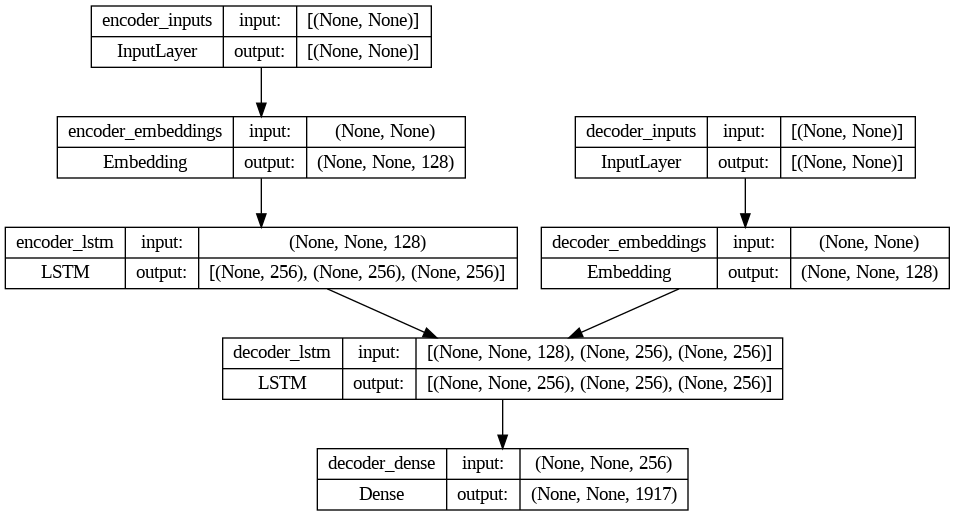

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='hun_eng_seq2seq_nmt_no_attention.png', show_shapes=True, show_layer_names=True)

Matrix dimensions

In [ ]:
print('encoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len)))
print()
print('encoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len, embedding_dim)))
print()
print('encoder_lstm layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len, embedding_dim), [(batch_size, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print()
print('decoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len)))
print()
print('decoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len, embedding_dim)))
print()
print('decoder_lstm layer\n input dimension {}\n output dimension: {}'.format([(batch_size, max_decoding_len, embedding_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)], [(batch_size, max_decoding_len, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print('decoder_dense layer(softmax)\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len, hidden_dim), (batch_size, max_decoding_len, target_vocab_size)))

encoder_inputs layer
 input dimension (16, 21)
 output dimension: (16, 21)

encoder_embeddings layer
 input dimension (16, 21)
 output dimension: (16, 21, 128)

encoder_lstm layer
 input dimension (16, 21, 128)
 output dimension: [(16, 256), (16, 256), (16, 256)]


decoder_inputs layer
 input dimension (16, 21)
 output dimension: (16, 21)

decoder_embeddings layer
 input dimension (16, 21)
 output dimension: (16, 21, 128)

decoder_lstm layer
 input dimension [(16, 21, 128), (16, 256), (16, 256)]
 output dimension: [(16, 21, 256), (16, 256), (16, 256)]

decoder_dense layer(softmax)
 input dimension (16, 21, 256)
 output dimension: (16, 21, 1917)


Model checkpoints

In [ ]:
filepath= r"E:\@capstone\datbase\train, test, val"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

Early stopping & Fit method

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1.5)
history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                      callbacks=[cp_callback, es_callback])

Epoch 1/30
146/146 [==============================] - ETA: 0s - loss: 4.6199 - sparse_categorical_accuracy: 0.2597
Epoch 1: saving model to E:\@capstone\datbase\train, test, val
146/146 [==============================] - 41s 284ms/step - loss: 4.6199 - sparse_categorical_accuracy: 0.2597 - val_loss: 4.3730 - val_sparse_categorical_accuracy: 0.2695
Epoch 2/30
146/146 [==============================] - ETA: 0s - loss: 4.3641 - sparse_categorical_accuracy: 0.2725
Epoch 2: saving model to E:\@capstone\datbase\train, test, val
146/146 [==============================] - 37s 252ms/step - loss: 4.3641 - sparse_categorical_accuracy: 0.2725 - val_loss: 4.1752 - val_sparse_categorical_accuracy: 0.2783
Epoch 3/30
146/146 [==============================] - ETA: 0s - loss: 4.1611 - sparse_categorical_accuracy: 0.2890
Epoch 3: saving model to E:\@capstone\datbase\train, test, val
146/146 [==============================] - 41s 281ms/step - loss: 4.1611 - sparse_categorical_accuracy: 0.2890 - val_loss:

Menyimpan model dan Tokenizer.

In [ ]:
import zipfile

model.save('endgame_NMT_no_attention')

!zip -r ./endgame_NMT_no_attention.zip ./endgame_NMT_no_attention
files.download("./endgame_NMT_no_attention.zip")

source_tokenizer_json = source_tokenizer.to_json()
with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

target_tokenizer_json = target_tokenizer.to_json()
with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

  adding: endgame_NMT_no_attention/ (stored 0%)
  adding: endgame_NMT_no_attention/keras_metadata.pb (deflated 91%)
  adding: endgame_NMT_no_attention/saved_model.pb (deflated 90%)
  adding: endgame_NMT_no_attention/fingerprint.pb (stored 0%)
  adding: endgame_NMT_no_attention/assets/ (stored 0%)
  adding: endgame_NMT_no_attention/variables/ (stored 0%)
  adding: endgame_NMT_no_attention/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: endgame_NMT_no_attention/variables/variables.index (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengambil model yang disimpan dan tokenizer yang disimpan dan mencobanya pada test data set.

In [ ]:
# Retrieve the tokenizers.

!wget https://github.com/RanggaAndaRahman123/Tokenizer-Model-Deployed-Model-dan-Notebook/blob/main/Tokenizer%2C%20Model%2C%20Deployed%20Model%2C%20dan%20Notebook/Avengers_Endgame/tokenizer_endgame_NMT_no_attention.zip

Saving tokenizer_endgame_NMT_no_attention.zip to tokenizer_endgame_NMT_no_attention.zip


{'tokenizer_endgame_NMT_no_attention.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\x18\t\xcfV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00#\x00\x00\x00tokenizer_endgame_NMT_no_attention/PK\x03\x04\x14\x00\x00\x00\x08\x00\xf0\x08\xcfV\xe7N\xe9I\xc1\xc6\x00\x00\xaaE\x03\x00<\x00\x00\x00tokenizer_endgame_NMT_no_attention/source_tokenizer (1).jsont\\\xd9\x82\xdc\xb6r\xfd\x15GYn\x16\'\xf1\xcch$\xd9Y?"oQ\xa2\x80M\x0c\x89&\t0 \xa1\xb9m\'\xf9\xf6T\x81XX\x07\xf4\x93=\x10\x88\xa5\xd6S\x0b\xfa\xc3o_?\xdcf\xb5m\xdf\xacZ\xf4\xd7\x0f\xbf\xfc\xf0\xf5\xc3\xbf\xb9I[\xf3\xab\xf6_?\xfcH\x7f\xde\x9c}3\x03\xff\x13\xcd\xb5a\xf9\xf6\xee|\xbf\xf1\xdf6\xcc3\xcfx3\xf3\xae\xfdv|\xfd\xf5\xeb\xd7\x0f\x7f\xfag\x7f\xfe\x17\x7f\xf9W\x7f\xfd7\x7f\xfb\xf7\xbf\xfc\xc3?\xfd\xeb\xbf\xd3\xd0\xd7\xff\xf8\xcfo\xff\xf5\xdb\xff\xfc\xef\xff}\xfd\xba\x7f\xfdj\x8f\x95g\xf7\xce\x9b\xfc\xf2\xc3\xee\x83\xe6\x81m\x9d\xcd~,\xf3C\xda|T\xfe\xdb\xac\xbf\xeb\x99\x87\xdf\xd4\xbc\xc5\x89\xce}\xff\xb6\xf31\x8f\xc9\xffH\x7f\xff\xf3\xf1A\xefna\x

In [ ]:
!unzip -o tokenizer_endgame_NMT_no_attention.zip

Archive:  tokenizer_endgame_NMT_no_attention.zip
   creating: tokenizer_endgame_NMT_no_attention/
  inflating: tokenizer_endgame_NMT_no_attention/source_tokenizer (1).json  
  inflating: tokenizer_endgame_NMT_no_attention/target_tokenizer (1).json  


Memuat tokenizer dengan metode tokenizer_from_json.

In [ ]:
with open('source_tokenizer.json') as f:
    data = json.load(f)
    source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open('target_tokenizer.json') as f:
    data = json.load(f)
    target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
# Retrieve the model.

!wget https://github.com/RanggaAndaRahman123/Tokenizer-Model-Deployed-Model-dan-Notebook/blob/main/Tokenizer%2C%20Model%2C%20Deployed%20Model%2C%20dan%20Notebook/Avengers_Endgame/endgame_NMT_no_attention.zip

Saving endgame_NMT_no_attention.zip to endgame_NMT_no_attention (1).zip


In [ ]:
!unzip -o endgame_NMT_no_attention.zip

Archive:  endgame_NMT_no_attention.zip
  inflating: endgame_NMT_no_attention/keras_metadata.pb  
  inflating: endgame_NMT_no_attention/saved_model.pb  
 extracting: endgame_NMT_no_attention/fingerprint.pb  
  inflating: endgame_NMT_no_attention/variables/variables.data-00000-of-00001  
  inflating: endgame_NMT_no_attention/variables/variables.index  


In [ ]:
# Load the model.
model = tf.keras.models.load_model('endgame_NMT_no_attention')

In [ ]:
# Retrieve the test dataset.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Endgame/endgmsubdatasets(3)_test.txt

Saving endgmsubdatasets(3)_test.txt to endgmsubdatasets(3)_test.txt


{'endgmsubdatasets(3)_test.txt': b"\xef\xbb\xbfOke, tunggu, jangan tembak.<sep>Okay, hold on, don't shoot.\r\nAnda melihat ke mana Anda pergi?  Mm-hmm.<sep>You see where you're going? Mm-hmm.\r\nOke.<sep>Okay.\r\nSekarang, mari kita khawatir tentang bagaimana Anda sampai di sana.<sep>Now, let's worry about how you get there.\r\nHarus pindah kaki Anda di sini.<sep>Gotta move your foot here.\r\nArahkan jari kaki Anda ke sini.<sep>Point your toe this way.\r\nPinggul Anda di sini.<sep>Your hips here.\r\nOke?<sep>Okay?\r\nBisakah kamu melihat?  Ya.<sep>Can you see? Yeah.\r\nApa kamu yakin?  Mm-hmm.<sep>Are you sure? Mm-hmm.\r\nBagaimana kalau sekarang?  Bisakah kamu melihat sekarang?<sep>How about now? Can you see now?\r\nTidak. Bagaimana dengan sekarang?<sep>No. How about now?\r\nBaiklah.<sep>All right.\r\nSiap?  Tiga jari.<sep>Ready? Three fingers.\r\nBagus!<sep>Nice!\r\nLemparan yang bagus, Nak.<sep>Nice throw, kiddo.\r\nIni dia.<sep>Here you go.\r\nHei, kalian mau mayo?  Atau mustar?<se

In [ ]:
with open('endgmsubdatasets(3)_test.txt', encoding='utf-8-sig') as file:
  test = [line.rstrip() for line in file]

In [ ]:
test[:3]

["Oke, tunggu, jangan tembak.<sep>Okay, hold on, don't shoot.",
 "Anda melihat ke mana Anda pergi?  Mm-hmm.<sep>You see where you're going? Mm-hmm.",
 'Oke.<sep>Okay.']

In [ ]:
# test dataset
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [ ]:
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

73/73 [==============================] - 11s 96ms/step - loss: 0.5332 - sparse_categorical_accuracy: 0.9097


[0.5332375168800354, 0.90970379114151]

Training model untuk kasus inference, dengan membuat stand-alone model encoder dan decoder terpisah.

In [ ]:
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

Membuat stand-alone encoder.

In [ ]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

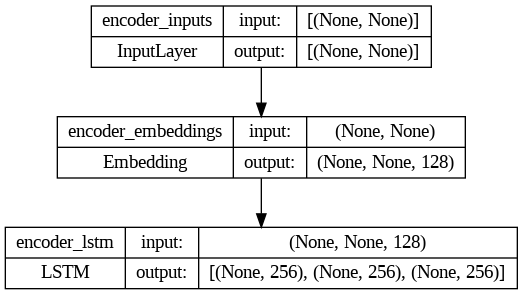

In [ ]:
plot_model(encoder_model_no_attention, to_file='encoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Membuat stand-alone decoder, dengan dua input tambahan ke dekoder yaitu LSTM hidden state (decoder_input_state_h) dan cell state (decoder_input_state_c).

Stand-alone decoder sekarang mengambil sebagai input: Token (sos) / output dari timestep sebelumnya. Hidden state dan cell state.

Menghasilkan distribusi probabilitas untuk output saat ini, dan hidden state dan cell state baru.

In [ ]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_input_state_h = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')

decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

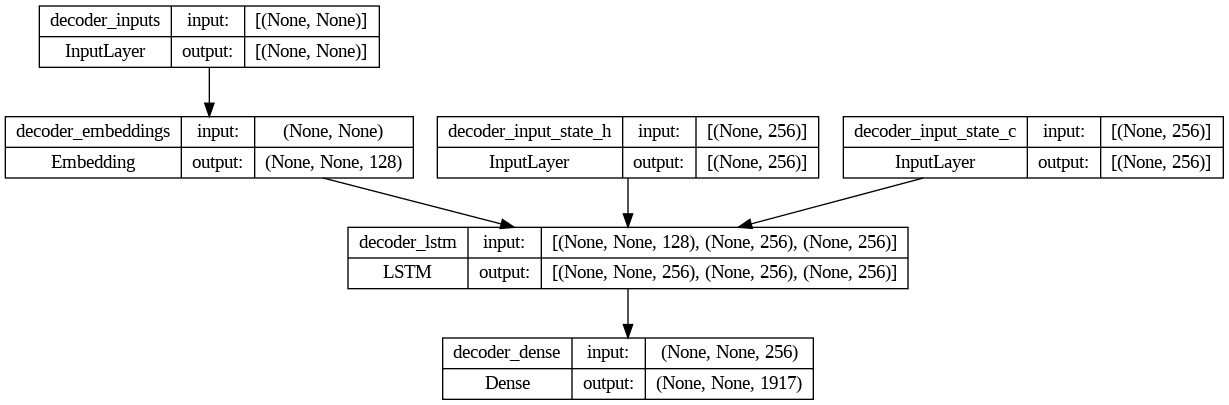

In [ ]:
plot_model(decoder_model_no_attention, to_file='decoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Metode menerjemahkan kalimat dari bahasa source ke bahasa target. Kata yang dihasilkan output dekoder dan hidden state dan cell state nya kemudian diberikan lagi ke dekoder hingga token (eos) dihasilkan.

In [ ]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                max_translated_len = 30):

  input_seq = source_tokenizer.texts_to_sequences([sentence])

  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]

    target_y_proba, h, c = decoder.predict([target_seq] + states)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c]

  return tokenized_sentence[0], ' '.join(decoded_sentence)

Pengujian dengan mengambil sampel kalimat-kalimat dari test dataset.

In [ ]:
random.seed(1)
sentences = random.sample(test, 2330)
sentences

["Kita akan membutuhkan otak yang sangat besar.<sep>We're gonna need a really big brain.",
 'Akan selalu begitu.<sep>It always will be.',
 'Apakah Anda pernah mendengarkan sesuatu?<sep>Have you been listening to anything?',
 "Jadi, saya akan...<sep>So, I'm gonna...",
 'Apa?<sep>What?',
 'Apakah Anda memberi tahu saya bahwa ini benar-benar berhasil?<sep>Are you telling me this actually worked?',
 "Jangan pindahkan dia.<sep>Don't move him.",
 'Mungkin aku memperlakukanmu terlalu kasar.<sep>Perhaps I treated you too harshly.',
 'Siapa yang mengayunkan Stormbreaker?<sep>Who was swinging Stormbreaker?',
 'semua orang bahwa mereka harus pindah...<sep>they should move on...',
 'Saya pikir dengan menghilangkan separuh kehidupan...<sep>I thought by eliminating half of life...',
 "Kenapa dia?<sep>What's wrong with him?",
 "Hanya itu saja.  Baiklah?  Kami menggunakan itu...<sep>That's it. All right? We use that...",
 "Secara teknis dia bukan rakun, lho?<sep>Technically he's not a raccoon, you kno

In [ ]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

Memuat hasil ke dalam Pandas DataFrame.

In [ ]:
translations_no_attention = pd.DataFrame(translate_sentences(sentences, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 [==============================] - 0s 34ms/step


,Tokenized Original,Reference,Translation
0,kita akan membutuhkan otak yang sangat besar .,We're gonna need a really big brain.,we can take that place was the quantum realm .
1,akan selalu begitu .,It always will be.,it always will be .
2,apakah anda pernah mendengarkan sesuatu ?,Have you been listening to anything?,have you been listening to anything ?
3,"jadi , saya akan . . .","So, I'm gonna...","so , i haven't . . ."
4,apa ?,What?,what ?
...,...,...,...
2325,quill bilang dia mencuri power stone dari morag .,Quill said he stole the Power Stone from Morag.,quill said he stole the power stone from morag .
2326,mungkin adalah kematian kolektif kita .,will be our collective demise.,will be our collective demise .
2327,apakah itu yang saya lakukan ? ya .,Is that what I did? Yeah.,is that what i know ? yeah .
2328,aku harus menelepon direktur .,I'm gonna have to call the director.,i have to try of it .


In [ ]:
translations_no_attention.to_excel('endgame_translations_no_attention.xlsx', index=False)

In [ ]:
import pandas as pd
from IPython.display import FileLin

# Membuat tautan unduhan
FileLink('endgame_translations_no_attention.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploy Model ke TensorFlow Lite

In [ ]:
!pip install tflite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pathlib
import tensorflow as tf

model = tf.keras.models.load_model('endgame_NMT_no_attention')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

7138852

In [ ]:
import shutil

# Menyalin file tflite_model ke direktori
shutil.copy(tflite_model_file, 'tflite_model.tflite')

# Mendownload file tflite_model
from IPython.display import FileLink
FileLink('tflite_model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>